In [1]:
import pandas as pd
import numpy as np
import anndata
import scanpy as sc

/home/yujia/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read 8k/10k data
pbmc8k = sc.read_10x_mtx("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/raw_dat/pbmc8k/filtered_gene_bc_matrices/GRCh38")
pbmc10k = sc.read_10x_mtx("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/raw_dat/pbmc10k/filtered_feature_bc_matrix")

In [3]:
pbmc8k.obs["IID"] = "pbmc8k"
pbmc10k.obs["IID"] = "pbmc10k"

In [4]:
pbmc8k.obs_names=['pbmc8k-'+x for x in pbmc8k.obs_names]
pbmc10k.obs_names=['pbmc10k-'+x for x in pbmc10k.obs_names]

#### PBMC8K

In [5]:
# sc.pl.highest_expr_genes(pbmc8k, n_top=20)

sc.pp.filter_cells(pbmc8k, min_genes=200)
sc.pp.filter_genes(pbmc8k, min_cells=3)

# annotate the group of mitochondrial genes as "mt"
pbmc8k.var["mt"] = pbmc8k.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    pbmc8k, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

# sc.pl.violin(
#     pbmc8k,
#     ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
#     jitter=0.4,
#     multi_panel=True,
# )

# sc.pl.scatter(pbmc8k, x="total_counts", y="pct_counts_mt")
# sc.pl.scatter(pbmc8k, x="total_counts", y="n_genes_by_counts")

pbmc8k = pbmc8k[pbmc8k.obs.n_genes_by_counts < 2500, :]
pbmc8k = pbmc8k[pbmc8k.obs.pct_counts_mt < 5, :].copy()

sc.pp.normalize_total(pbmc8k, target_sum=1e4)

sc.pp.log1p(pbmc8k)

sc.pp.highly_variable_genes(pbmc8k, min_mean=0.0125, max_mean=3, min_disp=0.5)

pbmc8k.raw = pbmc8k

pbmc8k = pbmc8k[:, pbmc8k.var.highly_variable]

sc.pp.regress_out(pbmc8k, ["total_counts", "pct_counts_mt"])

sc.pp.scale(pbmc8k, max_value=10)

sc.tl.pca(pbmc8k, svd_solver="arpack")

# sc.pl.pca(pbmc8k, color="CST3")
# sc.pl.pca_variance_ratio(pbmc8k, log=True)

sc.pp.neighbors(pbmc8k, n_neighbors=10, n_pcs=40)
sc.tl.umap(pbmc8k, n_components=4)

/home/yujia/miniconda3/envs/pytorch/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


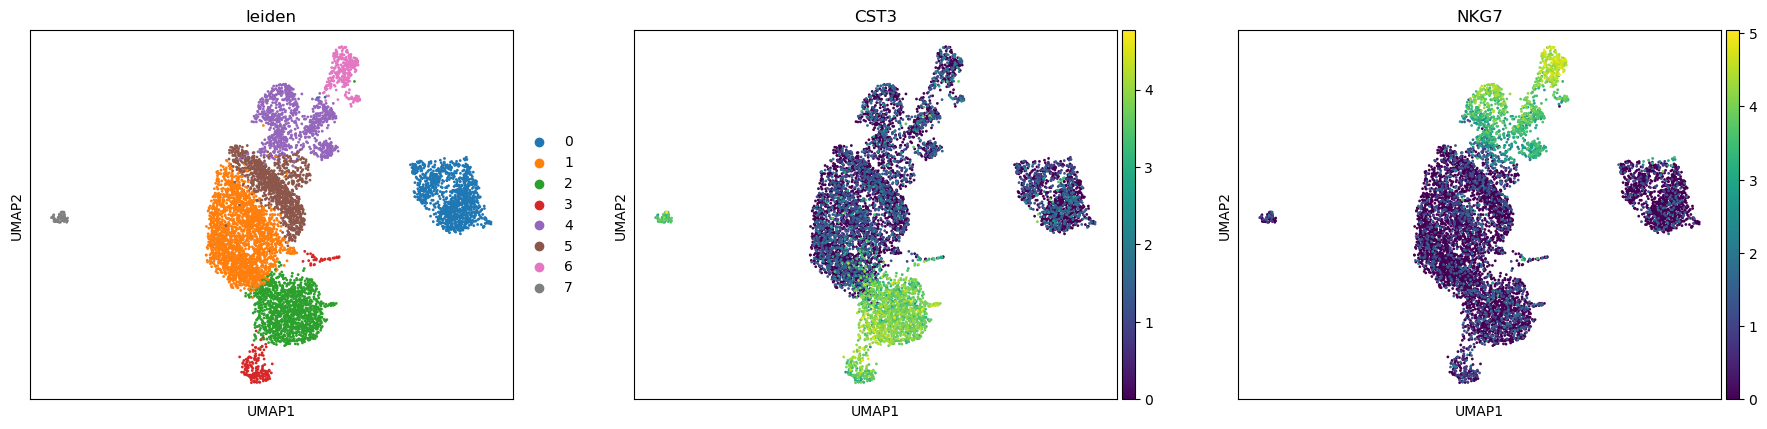

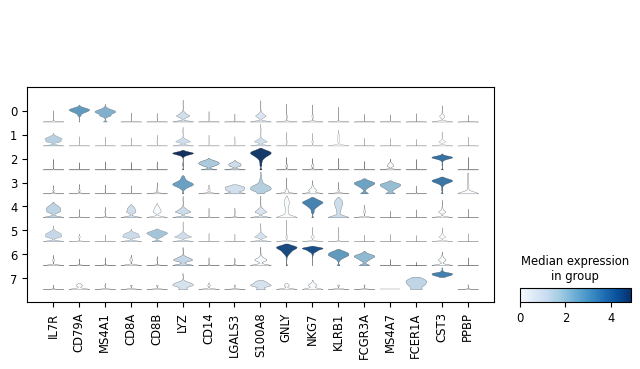

In [6]:
sc.tl.umap(pbmc8k, n_components=2)

sc.tl.leiden(
    pbmc8k,
    resolution=0.2,
    random_state=0,
    flavor="igraph",
    n_iterations=5,
    directed=False,
)

sc.pl.umap(pbmc8k, color=["leiden", "CST3", "NKG7"])

marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]
sc.pl.stacked_violin(pbmc8k, marker_genes, groupby="leiden")

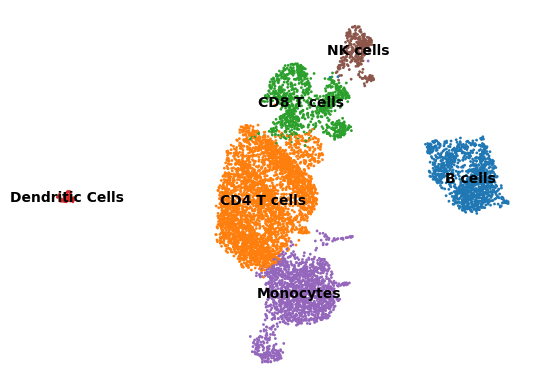

In [7]:
new_cluster_names = {
    "0": "B cells", # 0
    "1": "CD4 T cells", # 1
    "2": "Monocytes", # 2 CD14+ Monocytes
    "3": "Monocytes", # 3 FCGR3A+ Monocytes
    "4": "CD8 T cells", # 4
    "5": "CD4 T cells", # 5
    "6": "NK cells", # 6
    "7": "Dendritic Cells", # 7
}

pbmc8k.obs["cell_type"] = pbmc8k.obs["leiden"].to_list()
pbmc8k.obs.replace({"cell_type": new_cluster_names}, inplace=True) 
sc.pl.umap(
    pbmc8k, color="cell_type", legend_loc="on data", title="", frameon=False
)

#### PBMC10K

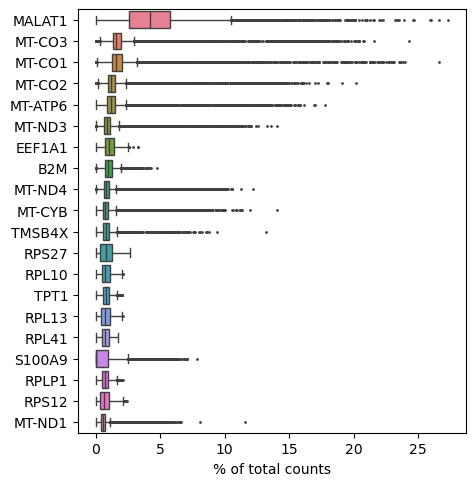

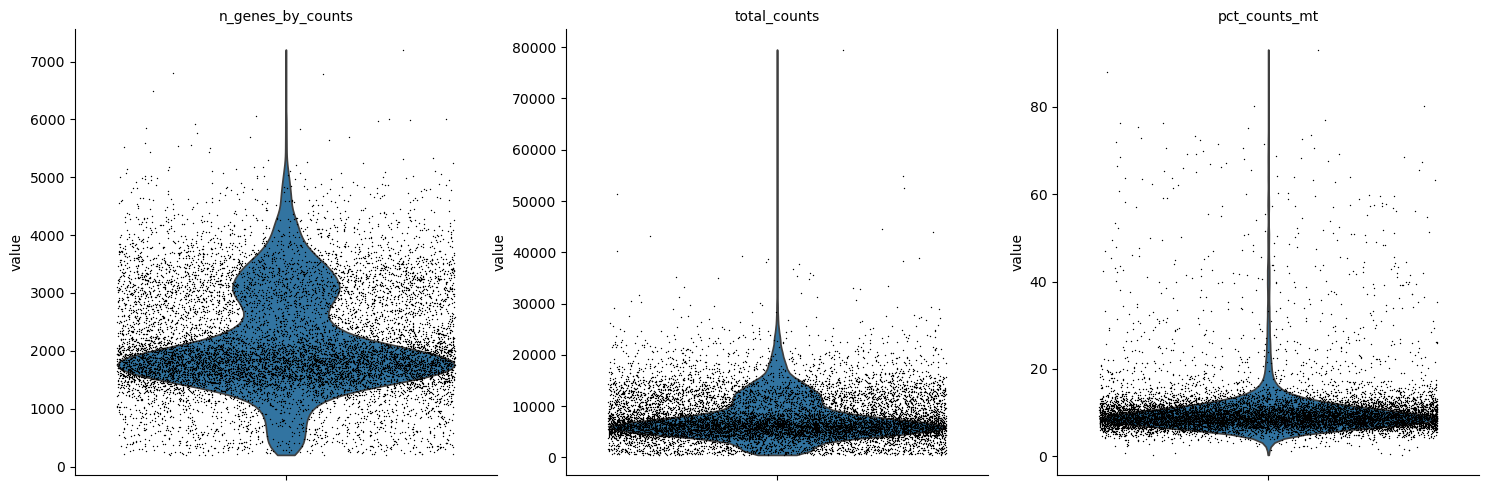

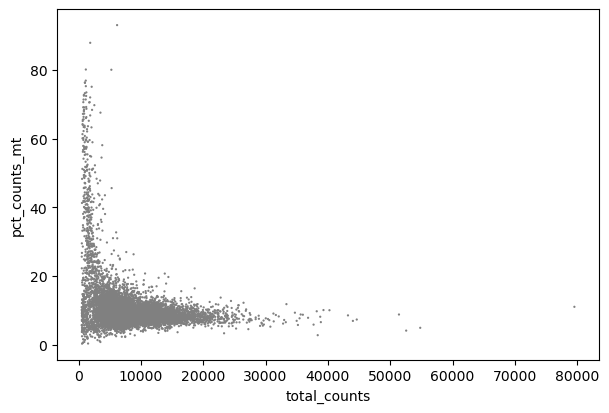

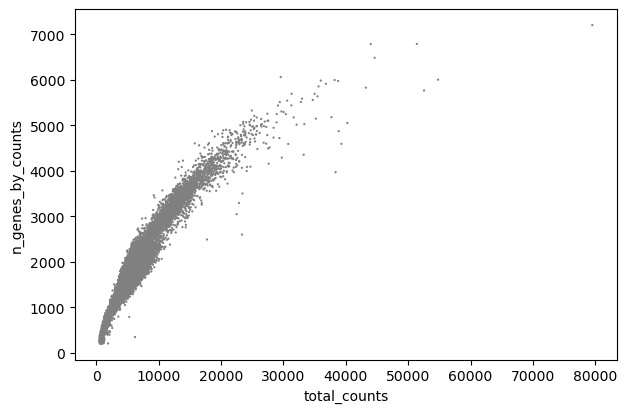

/home/yujia/miniconda3/envs/pytorch/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
sc.pl.highest_expr_genes(pbmc10k, n_top=20)

sc.pp.filter_cells(pbmc10k, min_genes=200)
sc.pp.filter_genes(pbmc10k, min_cells=3)

# annotate the group of mitochondrial genes as "mt"
pbmc10k.var["mt"] = pbmc10k.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    pbmc10k, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

sc.pl.violin(
    pbmc10k,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

sc.pl.scatter(pbmc10k, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(pbmc10k, x="total_counts", y="n_genes_by_counts")

pbmc10k = pbmc10k[pbmc10k.obs.n_genes_by_counts < 2500, :]
pbmc10k = pbmc10k[pbmc10k.obs.pct_counts_mt < 15, :].copy()

sc.pp.normalize_total(pbmc10k, target_sum=1e4)

sc.pp.log1p(pbmc10k)

sc.pp.highly_variable_genes(pbmc10k, min_mean=0.0125, max_mean=3, min_disp=0.5)

pbmc10k.raw = pbmc10k

pbmc10k = pbmc10k[:, pbmc10k.var.highly_variable]

sc.pp.regress_out(pbmc10k, ["total_counts", "pct_counts_mt"])

sc.pp.scale(pbmc10k, max_value=10)

sc.tl.pca(pbmc10k, svd_solver="arpack")

# sc.pl.pca(pbmc10k, color="CST3")
# sc.pl.pca_variance_ratio(pbmc10k, log=True)

sc.pp.neighbors(pbmc10k, n_neighbors=10, n_pcs=40)
sc.tl.umap(pbmc10k, n_components=4)

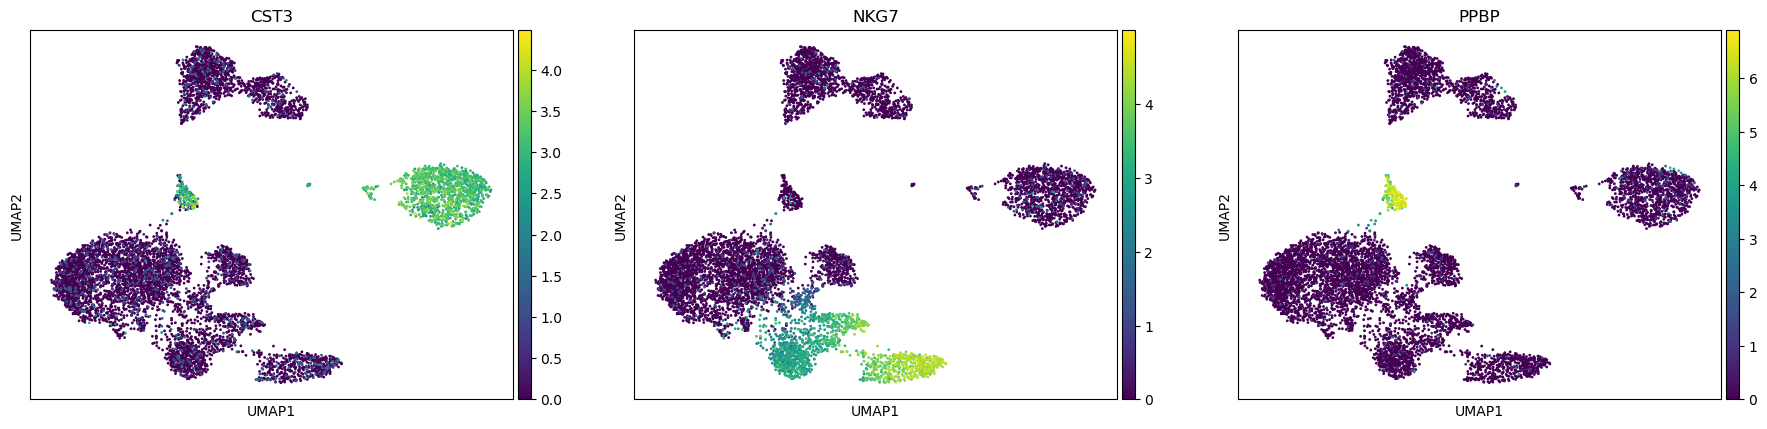

In [9]:
sc.tl.umap(pbmc10k, n_components=2)
sc.pl.umap(pbmc10k, color=["CST3", "NKG7", "PPBP"])

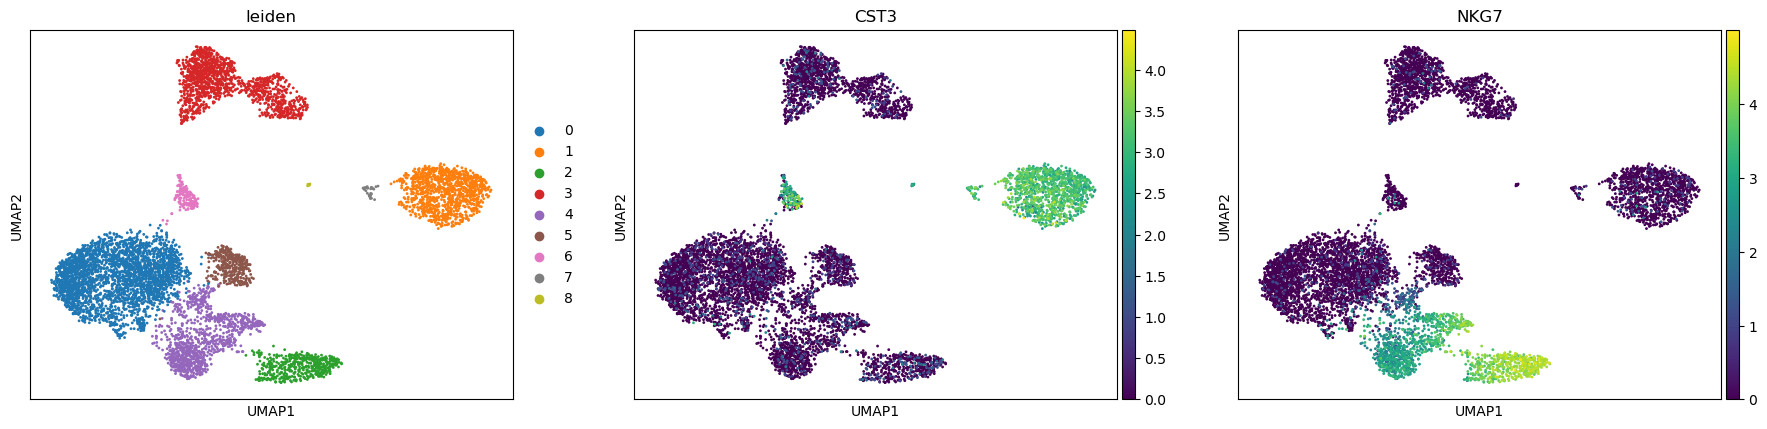

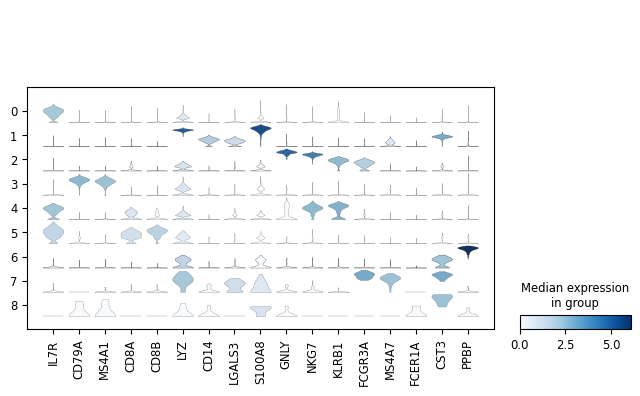

In [10]:
sc.tl.leiden(
    pbmc10k,
    resolution=0.2,
    random_state=0,
    flavor="igraph",
    n_iterations=5,
    directed=False,
)
sc.pl.umap(pbmc10k, color=["leiden", "CST3", "NKG7"])
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]
sc.pl.stacked_violin(pbmc10k, marker_genes, groupby="leiden")


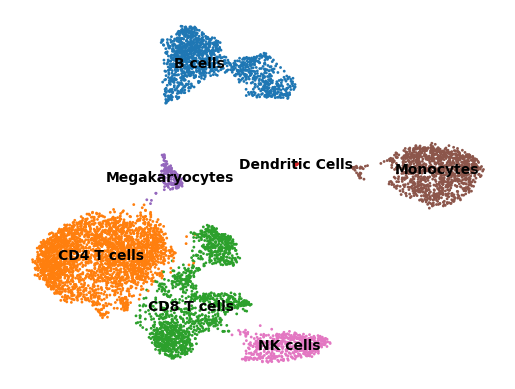

In [11]:
new_cluster_names = {
    "0": "CD4 T cells", # 0
    "1": "Monocytes", # 1 CD14+ Monocytes
    "2": "NK cells", # 2 
    "3": "B cells", # 3 
    "4": "CD8 T cells", # 4
    "5": "CD8 T cells", # 5
    "6": "Megakaryocytes", # 6
    "7": "Monocytes", # 7 FCGR3A+ Monocytes
    "8": "Dendritic Cells"
}

pbmc10k.obs["cell_type"] = pbmc10k.obs["leiden"].to_list()
pbmc10k.obs.replace({"cell_type": new_cluster_names}, inplace=True) 
sc.pl.umap(
    pbmc10k, color="cell_type", legend_loc="on data", title="", frameon=False
)

In [16]:
pbmc810k = sc.concat([pbmc8k, pbmc10k])
pbmc810k.write_h5ad("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/01_preprocess_h5ad/pbmc810k.h5ad")

In [37]:
X_mat = pd.DataFrame(pbmc810k.raw.X.todense())
X_mat.columns = pbmc810k.raw.var.index.to_list()
X_mat.index = pbmc810k.obs.index.to_list()

X_mat = X_mat[X_mat.columns.drop(list(X_mat.filter(regex='MT-')))]
X_mat.isnull().values.any()
X_mat.to_csv("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/01_preprocess_h5ad/pbmc810k_normalizedX.csv.gz", index=True)
pbmc810k.obs.to_csv("/home/yujia/project/2023-04-24-Cell-decomposition/cell_decomposition/dat/09_pbmc_data/01_preprocess_h5ad/pbmc810k_meta.csv")